# Machine Learning LAB 1 
Course 2022/23: F. Barbato, M. Mel, P. Zanuttigh

The notebook contains some simple tasks to be performed about **classification and regression**. <br>
Complete all the **required code sections** and **answer to all the questions**. <br>

### IMPORTANT for the evaluation score:
1. **Read carefully all cells** and **follow the instructions**
1. **Rerun all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
2. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
3. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command** - otherwise points will be deduced.
4. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## A) Classification of Day/Night

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB1.ipynb** otherwise your homework could get lost
<br>

**Student name**: Riccardo Tancredi<br>
**ID Number**: 2089395

### Dataset description

The data was recorded using the new **Luxottica I-SEE glasses** in exterior conditions. These devices provide multiple **sensors mounted inside the glasses**, which can be accessed through a bluetooth connection. <br>
For the **classification** part of the notebook we will focus on the **UVA**, **UVB** and **pressure** sensors, with the goal of discriminating between **day and night** time.

![I-SEE Glasses](data/isee.png "I-SEE")

We first **import** all **the packages** that are needed.

In [1]:
import csv
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model, preprocessing

Change some global settings for layout purposes.

In [2]:
# if you are in the jupyter notebook environment you can change the 'inline' option with 'notebook' to get interactive plots
%matplotlib inline
# change the limit on the line length and crop to 0 very small numbers, for clearer printing
np.set_printoptions(linewidth=500, suppress=True)

## A.1) Perceptron
In the following cells we will **implement** the **perceptron** algorithm and use it to learn a halfspace.

**TO DO (A.1.0):** **Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [3]:
IDnumber = 2089395 # YOUR_ID
np.random.seed(IDnumber)

Before proceding to the training steps, we **load the dataset and split it** in training and test set (the **training** set is **typically larger**, here we use a 75% training 25% test split).
The **split** is **performed after applying a random permutation** to the dataset, such permutation will **depend on the seed** you set above. Try different seeds to evaluate the impact of randomization.<br><br>
**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [4]:
def load_dset(filename, features=[2,3,9], label_id=-1, mode='clas'):
    # Load the dataset
    with open(filename, newline='\n') as f:
        raw_data = csv.reader(f, delimiter=',')
        header = next(raw_data)                # skip first line
        print(f"Header: {header}\n")

        dataset = np.array(list(raw_data))
        print(f"Data shape: {dataset.shape}\n")
        print("Dataset Example:")
        print(dataset[0,...])                  # print the first row of the dataset

    X = dataset[:,features].astype(float)      # extract the selected features, default refers to the first part of the lab: [uva, uvb, pressure]
    if mode == 'clas':
        Y = dataset[:,label_id].astype(int)    # if we are in classification mode, get the labels from the provided index as indices
        Y = 2*Y-1                              # for the perceptron night --> -1, day --> 1
    else:
        Y = dataset[:,label_id].astype(float)  # otherwise get them as floats

    m = dataset.shape[0]
    print("\nNumber of samples loaded:", m)
    permutation = np.random.permutation(m)     # random permutation

    X = X[permutation]
    Y = Y[permutation]
    
    return X, Y

In [5]:
# Load the dataset
X, Y = load_dset('data/lux.csv')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


We are going to differentiate (classify) between **class "1" (day)** and **class "-1" (night)**

# Split data in training and test sets



Given $m$ total data, denote with $m_{t}$ the part used for training. Keep $m_t$ data as training data, and $m_{test}:= m-m_{t}$. <br>
For instance one can take $m_t=0.75\:m$ of the data as training and $m_{test}=0.25\:m$ as testing. <br>
Let us define as

$\bullet$ $S_{t}$ the training data set

$\bullet$ $S_{test}$ the testing data set


The reason for this splitting is as follows:

TRAINING DATA: The training data are used to compute the empirical loss
$$
L_S(h) = \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
which is used to estimate $h$ in a given model class ${\cal H}$.
i.e. 
$$
\hat{h} = {\rm arg\; min}_{h \in {\cal H}} \, L_S(h)
$$

TESTING DATA: The test data set can be used to estimate the performance of the final estimated model
$\hat h_{\hat d_j}$ using:
$$
L_{{\cal D}}(\hat h_{\hat d_j}) \simeq \frac{1}{m_{test}} \sum_{ z_i \in S_{test}} \ell(\hat h_{\hat d_j},z_i)
$$

**TO DO (A.1.1):** **Divide** the **data into training and test set** (**75%** of the data in the **first** set, **25%** in the **second** one). <br>
<br>
Notice that as is common practice in Statistics and Machine Learning, **we scale the data** (= each variable) so that it is centered **(zero mean)** and has **standard deviation equal to 1**. <br>
This helps in terms of numerical conditioning of the (inverse) problems of estimating the model (the coefficients of the linear regression in this case), as well as to give the same scale to all the coefficients.

In [6]:
m = X.shape[0]
# compute the splits
m_training = round(m*75/100) # in this way the output is an int

# m_test is the number of samples in the test set (total-training)
m_test =  round(m*25*100) # the output is an int and m_training + m_test = m 

# X_training = instances for training set
X_training =  X[:m_training]
# Y_training = labels for the training set
Y_training =  Y[:m_training]

# X_test = instances for test set
X_test =   X[m_training:m]
# Y_test = labels for the test set
Y_test =  Y[m_training:m]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training = scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 1633
Number of samples in the test set: 544

Number of night instances in test: 259
Number of day instances in test: 285
Mean of the training input data: [ 0. -0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [-0.10182417 -0.09807512  0.13371899]
Std of the test input data: [0.72475979 0.73241241 0.98762594]


We **add a 1 in front of each sample** so that we can use a vector in **homogeneous coordinates** to describe all the coefficients of the model. This can be done with the function $hstack$ in $numpy$.

In [7]:
def to_homogeneous(X_training, X_test):
    # Add a 1 to each sample (homogeneous coordinates)
    X_training = np.hstack( [np.ones( (X_training.shape[0], 1) ), X_training] )
    X_test = np.hstack( [np.ones( (X_test.shape[0], 1) ), X_test] )
    
    return X_training, X_test

In [8]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.          0.30978388  0.31131978  0.08320364]
 [ 1.         -0.28187211 -0.25341274  1.50561169]
 [ 1.          1.29545727  1.18007789  0.32350285]
 [ 1.         -0.04711209 -0.05505866 -0.29545295]
 [ 1.         -0.46110041 -0.45244662  1.54314954]
 [ 1.          1.12840122  1.05253712  0.33539397]
 [ 1.          0.0474604   0.02584426 -1.69257588]
 [ 1.          0.66426839  0.60591019  0.44150124]
 [ 1.         -0.26133005 -0.24741599 -1.25335904]
 [ 1.         -0.0367964  -0.04675546 -1.78599989]]


**TO DO (A.1.2):** Now **complete** the function *perceptron*. <br>
The **perceptron** algorithm **does not terminate** if the **data** is not **linearly separable**, therefore your implementation should **terminate** if it **reached the termination** condition seen in class **or** if a **maximum number of iterations** have already been run, where one **iteration** corresponds to **one update of the perceptron weights**. In case the **termination** is reached **because** the **maximum** number of **iterations** have been completed, the implementation should **return the best model** seen throughout.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model (or the latest, if the termination condition is reached)
- $best\_error$: the *fraction* of misclassified samples for the best model

In [9]:
def count_errors(current_w, X, Y):
    # This function:
    # computes the number of misclassified samples
    # returns the index of the first misclassified sample
  
    pred = np.sign([np.dot(current_w, X[i]) for i in range(X.shape[0])])                            # pred must have the same shape as Y, hint: pred = np.sign( ... )
    wrong = np.array([True if pred[i] != Y[i] else False for i in range(pred.shape[0])])            # wrong has the same shape as pred and Y, contains boolean values
    num_misclassified = wrong.sum()                                                                 # num_misclassified contains the number of wrong predictions
    
    if num_misclassified > 0:
        index_misclassified = np.where(wrong)[0][0]
    else:
        index_misclassified = -1 # signaling value for termination
    
    return num_misclassified, index_misclassified
        
def perceptron_update(current_w, x, y):
    # Place in this function the update rule of the perceptron algorithm
    # Remember that numpy arrays can be treated as generalized variables
    # therefore given array a = [1,2,3,4], the operation b = 10*a will yield
    # b = [10, 20, 30, 40]
    new_w = current_w + x * y  
    return new_w

def perceptron(X, Y, max_num_iterations):
    
    # Initialize some support variables
    num_samples = X.shape[0]
    # best_errors will keep track of the best (minimum) number of errors
    # seen throughout training, used for the update of the best_w variable
    best_error = num_samples+1
    
    # Initialize the weights of the algorith with w=0
    curr_w = np.zeros(X.shape[1])
    # The best_w variable will be used to keep track of the best solution
    best_w = curr_w.copy()

    # compute the number of misclassified samples and the index of the first of them
    num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
    # update the 'best' variables
    if num_misclassified < best_error:
        best_error = num_misclassified
        best_w = curr_w
    
    # initialize the number of iterations
    num_iter = 0
    # Main loop continue until all samples correctly classified or max # iterations reached
    # Remember that to signify that no errors were found we set index_misclassified = -1
    while index_misclassified != -1 and num_iter < max_num_iterations:
        
        # Call the perceptron_update function using the found misclassified sample
        curr_w = perceptron_update(best_w, X[index_misclassified], Y[index_misclassified])
        
        # permute the dataset 
        # **IMPORTANT** use the SAME permutation for samples and labels
        per = np.random.permutation(X.shape[0])
        X = X[per]
        Y = Y[per]
        
        # repeat the error count and best variables update
        num_misclassified, index_misclassified = count_errors(curr_w, X, Y)
        # update the 'best' variables
        if num_misclassified < best_error:
            best_error = num_misclassified
            best_w = curr_w
        
        # update the iteration number
        num_iter += 1

    # as required, return the best error as a ratio with respect to the total number of samples
    best_error /= X.shape[0]
    
    return best_w, best_error


Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [10]:
# Now run the perceptron for 100 iterations
w_found, error = perceptron(X_training, Y_training, 100)
print("Training Error of perceptron (100 iterations): " + str(error))

Training Error of perceptron (100 iterations): 0.030006123698714023


**TO DO (A.1.3):** use the best model $w\_found$ to **predict the labels for the test dataset** and print the fraction of misclassified samples in the test set (the test error that is an estimate of the true loss).

In [11]:
num_errors, _ = count_errors(w_found, X_test,Y_test)

true_loss_estimate = num_errors/Y_test.shape[0]     # Error rate on the test set
# NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perceptron (100 iterations): 0.03676470588235294


**TO DO (A.Q1) [Answer the following]** <br>
What about the difference between the training error and the test error  in terms of fraction of misclassified samples? Explain what you observe. (Notice that with a very small dataset like this one results can change due to randomization, try to run with different random seeds if you get unexpected results).

<div class="alert alert-block alert-info">
**ANSWER A.Q1**:<br>

The difference between the training error and the test error in terms of fraction of misclassified samples is pretty close to 0. Trying to run the simulations with different random seeds, I got results very close to each other. Just for the sake of the argument, I have registered the training errors and the test errors obtained through 10 simulations - in other words by changing 10 times the initial random seed - and I have computed the mean and the standard deviation of the variable $x = \varepsilon_{test} - \varepsilon_{training}$. 

The result is $\overline{x} = (0.003\pm0.003)$, so the difference between the two types of error is close to 0.
 </div>

**TO DO (A.1.4):** Copy the code from the last 2 cells above in the cell below and repeat the training with 3000 iterations. Then print the error in the training set and the estimate of the true loss obtained from the test set.

In [12]:
w_found, error = perceptron(X_training, Y_training, 3000)
print("Training Error of perceptron (3000 iterations): " + str(error))

num_errors, _ =  count_errors(w_found, X_test,Y_test)

true_loss_estimate = num_errors/Y_test.shape[0]  
print("Test Error of perceptron (3000 iterations): " + str(true_loss_estimate))

Training Error of perceptron (3000 iterations): 0.06858542559706063
Test Error of perceptron (3000 iterations): 0.08088235294117647


**TO DO (A.Q2) [Answer the following]** <br>
What about the difference between the training error and the test error in terms of the fraction of misclassified samples) when running for a larger number of iterations? Explain what you observe and compare with the previous case.

<div class="alert alert-block alert-info">
**ANSWER A.Q2**:<br>

The difference between the training error and the test error for a large number of iterations is now more relevant. The test error is often higher then the training error, but of the same order of magnitude, as expected since the perceptron is trained to found the minumum error on the training set with no guarantee on the test set. Just for the sake of the argument, I have registered the training errors and the test errors obtained through 10 simulations - in other words by changing 10 times the initial random seed - and I have computed the mean and the standard deviation of the variable $x = \varepsilon_{test} - \varepsilon_{training}$.

The result is $\overline{x} = (0.007\pm0.005)$, so the difference between the two types of error is still close to 0, but a little bit higher. 

Training the _training set_ for a longer time did not bring any advantage to the performance of the algorithm on the _test set_ (the error oscillates and does not improve significantly).
</div>

# A.2) Logistic Regression
Now we use **logistic regression**, exploiting the implementation in **Scikit-learn**, to predict labels. We will also plot the decision boundaries of logistic regression.

We first load the dataset again.

In [13]:
# Load the dataset
X, Y = load_dset('data/lux.csv')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


**TO DO (A.2.1):** As for the previous part, **divide the data** into training and test (75%-25%) and **add a 1 as first component** to each sample.

In [14]:
m = X.shape[0]
# compute the splits
m_training = round(m*75/100)

# m_test is the number of samples in the test set (total-training)
m_test =  round(m*25/100)

# X_training = instances for training set
X_training =  X[:m_training]
# Y_training = labels for the training set
Y_training =  Y[:m_training]

# X_test = instances for test set
X_test =   X[m_training:m]
# Y_test = labels for the test set
Y_test =  Y[m_training:m]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("\nNumber of night instances in test:", np.sum(Y_test==-1))
print("Number of day instances in test:", np.sum(Y_test==1))

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test = scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

# # convert to homogeneous coordinates
# X_training, X_test = to_homogeneous(X_training, X_test)
# print("Training set in homogeneous coordinates:")
print(X_training[:10])

Number of samples in the train set: 1633
Number of samples in the test set: 544

Number of night instances in test: 260
Number of day instances in test: 284
Mean of the training input data: [-0.  0.  0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [-0.00443739  0.00378289  0.0533368 ]
Std of the test input data: [1.08733401 1.12554035 1.0335342 ]
[[ 0.35189921  0.32746672  0.18798113]
 [-0.48337296 -0.46666732  0.25069946]
 [-0.47737619 -0.46577251  1.56952425]
 [ 1.03007628  1.00211995  0.82799887]
 [-0.48337296 -0.46837558 -0.25572174]
 [-0.113972   -0.09604894  0.07491879]
 [-0.48382923 -0.46698916 -0.51231611]
 [-0.47628218 -0.46726752  0.36106778]
 [-0.15741223 -0.14328688  1.49815588]
 [-0.46346989 -0.4408862  -1.07937841]]


To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. <br>
See the Scikit-learn documentation for how to use it [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

**TO DO (A.2.2):** **Define** the **logistic regression** model, then **learn** the model using **the training set** and **predict** on the **test set**. Then **print** the **fraction of samples misclassified** in the training set and in the test set.

In [15]:
# part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs')  # C should be very large to ignore regularization (see above)
                                                                 # <solver='lbfgs'> was added in order to avoid FutureWarning error, 
                                                                 # due to the fact that the dafault solver is not ideal for multiclass
                                                                 # problems. "<solver=‘liblinear’> is limited to one-versus-rest schemes". 

# learn from training set: hint use fit(...)
logreg = logreg.fit(X_training, Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/X_training.shape[0]
print("Error rate on training set: "+str(error_rate_training))

# predict on test set
predicted_test = logreg.predict(X_test)

#print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test = error_count_test/X_test.shape[0]
print("Error rate on test set: " + str(error_rate_test))

Intercept: [-11.0741408]
Coefficients: [[ 52.70619585 -86.26989426   0.96180741]]
Error rate on training set: 0.039804041641151255
Error rate on test set: 0.025735294117647058


**TO DO (A.2.3)** Now **pick two features** and restrict the dataset to include only two features, whose indices are specified in the $idx0$ and $idx1$ variables below. Then split into training and test.

In [16]:
# we define some additional variables:
#    feature_names  == name to display on the plots
#    feature_scales == scale (linear/log) to use for that metric
# this will be referred to in the following cell - to plot the values
feature_names  = ["UVA", "UVB", "Atm. Pressure"]
feature_scales = ["log", "log", "linear"]

# remember that we selected 3 sensors (uva, uvb, pressure), therefore
# to make the plot we need to reduce the data to 2D, so we choose two of them
# to do so change the following indices (between 0 and 2, inclusive)
idx0 = 0
idx1 = 1

X_reduced = X[:,[idx0, idx1]]

# re-initialize the dataset splits, with the reduced sets
X_training = X_reduced[:m_training]
Y_training = Y[:m_training]

X_test = X_reduced[m_training:m]
Y_test = Y[m_training:m]

Now learn a model using the training data and measure the performances.

In [17]:
# learning from training data
logreg = linear_model.LogisticRegression(C=1e5, solver='lbfgs').fit(X_training, Y_training)
print("Intercept:" , logreg.intercept_)
print("Coefficients:" , logreg.coef_)

# predict on training set
predicted_training = logreg.predict(X_training)

# predict on test set
predicted_test = logreg.predict(X_test)

# print the error rate = fraction of misclassified samples
error_count_training = (predicted_training != Y_training).sum()
error_rate_training = error_count_training/X_training.shape[0]
print("Error rate on training set: "+str(error_rate_training))

# print the error rate = fraction of misclassified samples
error_count_test = (predicted_test != Y_test).sum()
error_rate_test = error_count_test/X_test.shape[0]
print("Error rate on training set: "+str(error_rate_test))

Intercept: [2.37822323]
Coefficients: [[ 15.7189626  -84.15562394]]
Error rate on training set: 0.04102878138395591
Error rate on training set: 0.027573529411764705


**TO DO (A.Q3) [Answer the following]** <br>
Which features did you select and why? <br>
Compare the perfomance of the classifiers trained with every combination of two features with that of the baseline (which used all 3 features).

<div class="alert alert-block alert-info">
**ANSWER A.Q3**:<br>

I selected **UVA** and **UVB** as features, since **pressure** varies throughout the day, but _UV_ rays depend directly by the presence or absence of the sun. So, even though every combination of features produces the same _error on the training set_, I have chosen the first two because also in better agreement with the previous baseline fit (the one that uses all 3 features).
</div>

If everything is ok, the code below uses the model in $logreg$ to plot the decision region for the two features chosen above, with colors denoting the predicted value. It also plots the points (with correct labels) in the training set. It makes a similar plot for the test set.

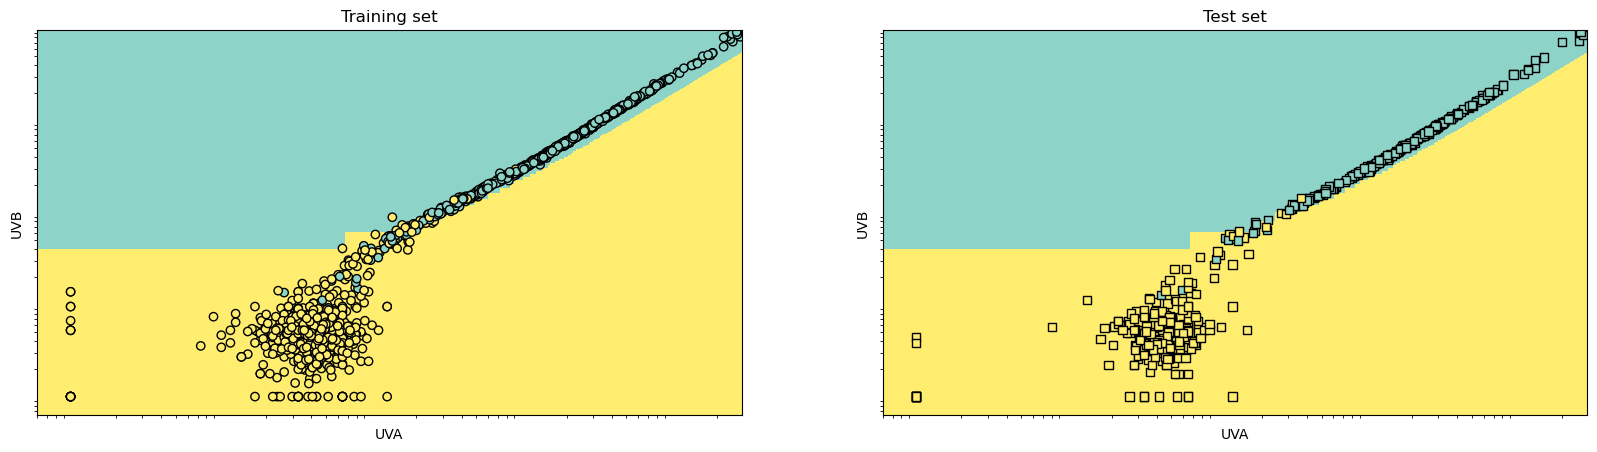

In [18]:
#firstly we import an additional module to suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# shift all the values to positive, to avoid problems with log-log plots
shift = .001 - X_reduced.min(axis=0)

fig, axs = plt.subplots(1, 2, figsize=(20,5))
axs[0].pcolormesh(xx + shift[0], yy + shift[1], Z, cmap=plt.cm.Set3)
axs[1].pcolormesh(xx + shift[0], yy + shift[1], Z, cmap=plt.cm.Set3)

# Plot also the training points
axs[0].scatter(X_training[:, 0] + shift[0], X_training[:, 1] + shift[1], c=Y_training, edgecolors='k', cmap=plt.cm.Set3)

axs[0].set_xlabel(feature_names[idx0])
axs[0].set_ylabel(feature_names[idx1])
axs[0].set_xscale(feature_scales[idx0])
axs[0].set_yscale(feature_scales[idx1])

axs[0].set_xlim(xx.min(), xx.max())
axs[0].set_ylim(yy.min(), yy.max())
axs[0].set_xticks(())
axs[0].set_yticks(())
axs[0].set_title('Training set')

# Plot also the test points 
axs[1].scatter(X_test[:, 0] + shift[0], X_test[:, 1] + shift[1], c=Y_test, edgecolors='k', cmap=plt.cm.Set3, marker='s')
axs[1].set_xlabel(feature_names[idx0])
axs[1].set_ylabel(feature_names[idx1])
axs[1].set_xscale(feature_scales[idx0])
axs[1].set_yscale(feature_scales[idx1])

axs[1].set_xlim(xx.min(), xx.max())
axs[1].set_ylim(yy.min(), yy.max())
axs[1].set_xticks(())
axs[1].set_yticks(())
axs[1].set_title('Test set')

plt.show()

# finally turn the warnings back on
warnings.filterwarnings("default")

# B) Linear Regression on the Atmospheric Conditions

As before, these **samples** were **extracted from** a Luxottica **I-SEE** device. <br>
For the **second part** of the laboratory we will **focus on linear regression**. We will try to estimate the **atmospheric pressure** starting from **temperature** and **relative humidity**.

First of all, we load again the dataset. Notice that the indices of the features were changed!

In [19]:
# Load the dataset
X, Y = load_dset('data/lux.csv', [0,1], 9, mode='reg')

Header: ['rh', 'temp', 'uva', 'uvb', 'x', 'y', 'blueg', 'blueb', 'worn', 'pressure', 'timestamp', 'hour', 'minute', 'second', 'isnight']

Data shape: (2177, 15)

Dataset Example:
['23.846666666666668' '37.21333333333334' '5.577416666666666' '1.6235333333333333' '615.7777777777778' '686.0' '134.0' '117.0' '0.0' '1.000291690654385' '1650458376' '14' '39' '36' '0']

Number of samples loaded: 2177


**TO DO (B.1)**: split the data in training and test sets (70%-30%)

In [20]:
m = X.shape[0]
# compute the splits
m_training = round(m*75/100)

# m_test is the number of samples in the test set (total-training)
m_test =  round(m*25/100)

# X_training = instances for training set
X_training =  X[:m_training]
# Y_training = labels for the training set
Y_training =  Y[:m_training]

# X_test = instances for test set
X_test =   X[m_training:m]
# Y_test = labels for the test set
Y_test =  Y[m_training:m]

# standardize the input matrix
# the transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Mean of the training input data: [ 0. -0.]
Std of the training input data: [1. 1.]
Mean of the test input data: [ 0.05480247 -0.01065124]
Std of the test input data: [1.03154564 1.05124927]


# Model Training 

The model is trained (= estimated) minimizing the empirical error
$$
L_S(h) := \frac{1}{m_t} \sum_{z_i \in S_{t}} \ell(h,z_i)
$$
When the loss function is the quadratic loss
$$
\ell(h,z) := (y - h(x))^2
$$
we define  the Residual Sum of Squares (RSS) as
$$
RSS(h):= \sum_{z_i \in S_{t}} \ell(h,z_i) = \sum_{z_i \in S_{t}} (y_i - h(x_i))^2
$$ so that the training error becomes
$$
L_S(h) = \frac{RSS(h)}{m_t}
$$

We recal that, for linear models we have $h(x) = <w,x>$ and the Empirical error $L_S(h)$ can be written
in terms of the vector of parameters $w$ in the form
$$
L_S(w) = \frac{1}{m_t} \|Y - X w\|^2
$$
where $Y$ and $X$ are the matrices whose $i-th$ row are, respectively, the output data $y_i$ and the input vectors $x_i^\top$. 

**TO DO (B.2):** compute the linear regression coefficients using np.linalg.lstsq from scikitlearn

In [21]:
X_trainingH, X_testH =  to_homogeneous(X_training, X_test)
X_trainingH[0].T

array([ 1.        , -2.35525803,  1.20373333])

In [22]:
#add a 1 at the beginning of each sample for training, and testing (use homogeneous coordinates)
X_trainingH, X_testH =  to_homogeneous(X_training, X_test)

print("Training set in homogeneous coordinates:")
print(X_trainingH[:10])

# Compute the least-squares coefficients using linalg.lstsq
w_np, RSStr_np, rank_Xtr, sv_Xtr =   np.linalg.lstsq(X_trainingH, Y_training, rcond=None) # rcond=None avoids warning message

print("LS coefficients with numpy lstsq:", w_np)

# compute Residual sums of squares 
Y_trainingR = Y_training  # recall that in Python 1D array of size n and 2D matrix nx1 are different
RSStr_train = np.array([pow(Y_trainingR[i]-np.dot(w_np, X_trainingH[i]), 2) for i in range(Y_trainingR.shape[0])]).sum() # compute error
print("RSS computed with the above formula: ", RSStr_train)
print("RSS with numpy lstsq: ", RSStr_np)
print("Empirical risk with numpy lstsq:", RSStr_np/m_training)

Training set in homogeneous coordinates:
[[ 1.         -2.35525803  1.20373333]
 [ 1.          1.44666859 -0.57297824]
 [ 1.          0.16288831 -0.86808878]
 [ 1.          0.13092537  1.50560162]
 [ 1.         -0.94693793 -0.86113661]
 [ 1.          1.23773363 -0.47418804]
 [ 1.         -0.12164854  0.34774057]
 [ 1.         -0.53016743  2.0131547 ]
 [ 1.          0.77765512 -0.01623795]
 [ 1.         -1.20975439  0.14417479]]
LS coefficients with numpy lstsq: [ 0.99308858 -0.00322669 -0.00004755]
RSS computed with the above formula:  0.009511375248815743
RSS with numpy lstsq:  [0.00951138]
Empirical risk with numpy lstsq: [0.00000582]


## Data prediction 

Compute the output predictions on both training and validation set and compute the Residual Sum of Sqaures (RSS). 

**TO DO (B.3)**: Compute these quantities on  training, validation and test sets.

In [23]:
#compute predictions on training and validation

#prediction_training 
prediction_training =  np.array([np.dot(w_np, X_trainingH[i]) for i in range(X_trainingH.shape[0])])
#prediction_test
prediction_test =  np.array([np.dot(w_np, X_testH[i]) for i in range(X_testH.shape[0])])

#what about the loss for points in the test data?
RSS_test =  np.array([pow(Y_test[i]-prediction_test[i], 2) for i in range(Y_test.shape[0])]).sum()

print("RSS on test data:",  RSS_test)
print("Loss estimated from test data:", RSS_test/m_test)

RSS on test data: 0.0030015113406626336
Loss estimated from test data: 5.517484082100429e-06


**TO DO (B.Q1) [Answer the following]** <br>
Comment on the results you get and on the difference between the train and test errors.

<div class="alert alert-block alert-info">
**ANSWER B.Q1**:<br>

The results are very similar to each other, meaning that the model is not over- (or under-) fitting the system under study. In particular, on the test set it seems that the algorithm performs better, and this is wondrous for our goal.
</div>

Now let's plot the data and check our estimation result.

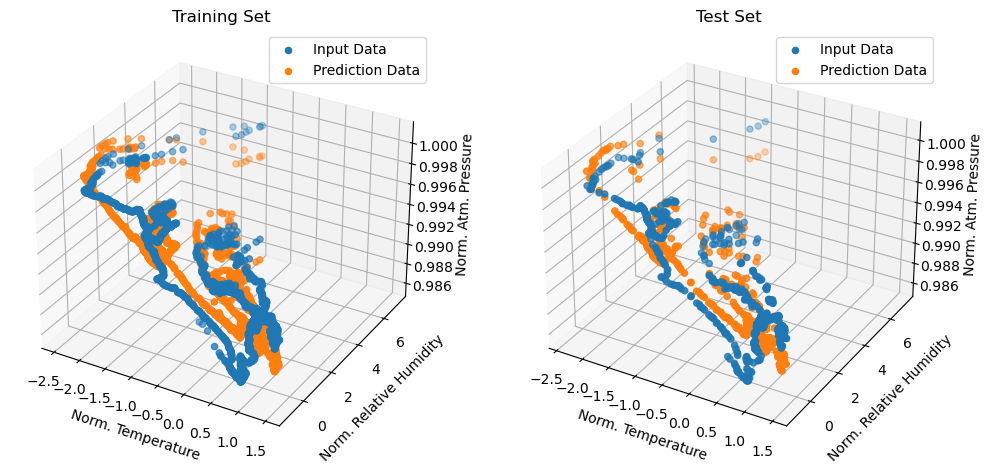

In [24]:
fig = plt.figure(figsize=(12,8))

from mpl_toolkits import mplot3d

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.scatter(X_training[:,0], X_training[:,1], Y_training, label="Input Data")
ax1.scatter(X_training[:,0], X_training[:,1], prediction_training, label="Prediction Data")
ax1.set_xlabel("Norm. Temperature")
ax1.set_ylabel("Norm. Relative Humidity")
ax1.set_zlabel("Norm. Atm. Pressure")
ax1.set_title("Training Set")
ax1.legend()

ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.scatter(X_test[:,0], X_test[:,1], Y_test, label="Input Data")
ax2.scatter(X_test[:,0], X_test[:,1], prediction_test, label="Prediction Data")
ax2.set_xlabel("Norm. Temperature")
ax2.set_ylabel("Norm. Relative Humidity")
ax2.set_zlabel("Norm. Atm. Pressure")
ax2.set_title("Test Set")
ax2.legend()
plt.show()

## Ordinary Least-Squares using scikit-learn
Another fast way to compute the LS estimate is through sklearn.linear_model

In [25]:
LinReg = linear_model.LinearRegression()  # build the object LinearRegression
LinReg.fit(X_training, Y_training)  # estimate the LS coefficients
print("Intercept:", LinReg.intercept_)
print("Least-Squares Coefficients:", LinReg.coef_)
prediction_training = LinReg.predict(X_training)  # predict output values on training set
prediction_test = LinReg.predict(X_test)  # predict output values on test set
print("Measure on training data:", 1-LinReg.score(X_training, Y_training))
print("Measure on test data:", 1-LinReg.score(X_test, Y_test))

Intercept: 0.9930885828247447
Least-Squares Coefficients: [-0.00322669 -0.00004755]
Measure on training data: 0.361049651621695
Measure on test data: 0.3738973750481278


#### **Final comment**
The results of the scikit-learn LinearRegression() function is the same of the least-square function computed from numpy. 
The goodness of the model is manifested by the _score_ function: the model works quite good, although we could test other hypothesis, besides the linear one.